# 使用预训练模型与模型部署

| ![](../../_static/logo/megvii-32.svg) [在 MegStudio 运行](https://studio.brainpp.com/project/#) | ![](../../_static/logo/github-32.svg) [查看源文件](https://github.com/MegEngine/Documentation/blob/main/source/getting-started/beginner/pretrained-model-and-deployment) |
| --- | --- |

收集数据、使用深度学习框架训练模型并不是整个机器学习流程的全部，我们的最终目的是希望这些模型能够被部署到实际的生产情景中去，并且有效地发挥作用。
在某些时候，负责模型部署的开发者仅仅关注如何将这些现成的模型用于推理情景；亦或者希望借助一些已经训练好的模型在新的任务上进行微调，从而快速获得不错的预测性能。通过这个教程，你将接触到以下内容：

- 了解 ResNet 模型结构的核心思想，看它解决了哪些 VGG 等模型结构没有解决的问题；
- 了解预训练模型的用途，借助在 ImageNet 数据集上预训练好的 ResNet 模型，完成 CIFAR10 图像分类；
- 了解模型部署的有关概念，理解工业界在做业务落地时的关注点，体会 MegEngine 如何发挥作用。

除了强大的工程实现能力外，核心思路的突破很重要，我们在前面的教程中接触了很多代码，在作为系列结尾的这篇教程中，将提供更多概念上的解释。

我们还将为你提供后续学习方向的建议，希望你最终能够成为一个高效率的 MegEngine 使用者。

请先运行下面的代码，检验你的环境中是否已经安装好 MegEngine（[安装教程](https://megengine.org.cn/doc/stable/zh/user-guide/install/)）：

In [1]:
import megengine

print(megengine.__version__)

%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import megengine.autodiff as autodiff
import megengine.data as data
import megengine.data.transform as T
import megengine.functional as F
import megengine.module as M
import megengine.optimizer as optim

1.5.0


## 残差网络（ResNet）

我们通过一些实践验证了深层的网络确实比浅层的网络具有更好的效果，但为什么我们不设计出一个具深无比的网络，来达到更好的性能呢？
这里引用了来自 [Tnil](https://www.zhihu.com/people/tylin98) 的解释（ 完整内容建议 [阅读原文](https://zhuanlan.zhihu.com/p/80226180) ）：

### 深度神经网络的“两朵乌云”

一个前馈神经网络 $f(\mathbf{x} ; \theta)$ ，由若干层神经元组成，为了方便讨论，我们以非线性单元（若干层神经元组成的函数单元）为单位讨论神经网络，即神经网络 $f(\mathbf{x} ; \theta)$ 由 $L$ 个非线性单元堆叠而成（后面将每个单元称为一层），令 $\mathbf{a}^{(0)}=\mathbf{x}$ , 则神经网络第 $l$ 层（ $1 \leq l \leq L$ ）的净输入 $\mathbf{z}^{(l)}$ 与输出 $\mathbf{a}^{(l)}$ 的计算由下式给出：

$$
\begin{aligned}
&\mathbf{z}^{(l)}=\mathcal{H}\left(\mathbf{a}^{(l-1)}\right) \\
&\mathbf{a}^{(l)}=g\left(\mathbf{z}^{(l)}\right)
\end{aligned}
$$

其中 $\mathcal{H}(\cdot)$ 是该层的内部运算，依照网络类型有所不同；$g(\cdot)$ 是第 $l$ 层的输出激活函数。

一般认为，经过训练的深度神经网络能够将数据特征逐层抽象，最终提取出完成任务所需要的特征/表示，最终使用一个简单的分类器（或其他学习器），就可以完成最终任务——因此深度学习也被叫做表示/特征学习。

在“层层抽象”的直觉下，很自然的想法就是，训练一个很深的前馈神经网路，来完成任务。直观上看，更深的神经网络，在非线性激活函数的加持下，拥有更大的假设空间，因此当然“更有可能”包含了一个最优解。但是在实际使用时，训练又成了一个难题。除了过拟合问题以外，更深的神经网络会遇到如下两个难题，我姑且按照物理史的比喻将其称为深度神经网络的“两朵乌云”：

#### 梯度弥散/爆炸

现代神经网络一般是通过基于梯度的 BP 算法来优化，对前馈神经网络而言，一般需要前向传播输入信号，然后反向传播误差并使用梯度方法更新参数。第 $l$ 层的某参数更新需要计算损失 $\epsilon$ 对其的梯度，该梯度依赖于该层的误差项 $\delta^{(l)}=\frac{\partial \epsilon}{\partial \mathbf{z}^{(l)}}$, 根据链式法则，其依赖后一层的误差项 $\delta^{(l+1)}$:

$$
\delta^{(l)}=\frac{\partial \mathbf{z}^{(l+1)}}{\partial \mathbf{z}^{(l)}} \cdot \delta^{(l+1)}
$$

假设网络单元输入输出维度一致，定义 $\gamma^{(l)} \simeq\left\|\frac{\partial \mathbf{z}^{(l+1)}}{\partial \mathbf{z}^{(l)}}\right\|$, 则有：

$$
\delta^{(l)} \simeq \gamma^{(l)} \delta^{(l+1)}
$$

当 $\gamma^{(l)}<1$ 时，第 $l$ 层的误差项较后一层减小，如果很多层的情况都是如此，就会导致反向传播中，梯度逐渐消失，底层的参数不能有效更新，这也就是梯度弥散(或梯度消失)；当 $\gamma^{(l)}>1$ 时，则会使得梯度以指数级速度增大，造成系统不稳定，也就是梯度爆炸问题。

**在很深层的网络中，由于不能保证** $\gamma^{(l)}$ **的大小，也很容易出现梯度弥散/爆炸。** 这是两朵乌云中的第一朵。

#### 网络退化问题

在前面的讨论中，梯度弥散/爆炸问题导致模型训练难以收敛，但是这个问题很大程度上已经被标准初始化和中间层正规化方法有效控制了（参考上一篇教程中提到的神经网络训练技巧），这些方法使得深度神经网络可以收敛。深度神经网络面临的另一朵乌云是网络退化问题：

在神经网络可以收敛的前提下，随着网络深度增加，网络的表现先是逐渐增加至饱和，然后迅速下降。需要注意，网络退化问题不是过拟合导致的，即便在模型训练过程中，同样的训练轮次下，退化的网络也比稍浅层的网络的训练错误更高。

这一点并不符合常理：如果存在某个 $K$ 层的网络 $f$ 是当前最优的网络，那么可以构造一个更深的网络，其最后几层仅是该网络 $f$ 第 $K$ 层输出的恒等映射（Identity Mapping）就可以取得与 $f$ 一致的结果；也许 $K$ 还不是所谓“最佳层数”，那么更深的网络就可以取得更好的结果。总而言之，与浅层网络相比，更深的网络的表现不应该更差。因此，一个合理的猜测就是， **对神经网络来说，恒等映射并不容易拟合。**

也许我们可以对网络单元进行一定的改造，来改善退化问题？这也就引出了残差网络的基本思路...

### 形式化定义与实现

既然神经网络不容易拟合一个恒等映射，那么一种思路就是构造天然的恒等映射。假设神经网络非线性单元的输入和输出维度一致，可以将神经网络单元内要拟合的函数 $\mathcal{H}(\cdot)$ 拆分成两个部分，即：

$$
\mathbf{z}^{(l)}=\mathcal{H}\left(\mathbf{a}^{(l-1)}\right)=\mathbf{a}^{(l-1)}+\mathcal{F}\left(\mathbf{a}^{(l-1)}\right)
$$

其中 $\mathcal{F}(\cdot)$ 是残差函数。在网络高层，学习一个恒等映射 $\mathcal{H}\left(\mathbf{a}^{(l-1)}\right) \rightarrow \mathbf{a}^{(l-1)}$ 即等价于令残差部分趋近于0，即 $\mathcal{F}\left(\mathbf{a}^{(l-1)}\right) \rightarrow \mathbf{0}$.

残差单元可以以跳层连接的形式实现，即将单元的输入直接与单元输出加在一起，然后再激活。因此残差网络可以轻松地用主流的自动微分深度学习框架实现，直接使用 BP 算法更新参数。

![residual](../../_static/images/residual.jpg)

实验表明，残差网络很好地解决了深度神经网络的退化问题，并在 ImageNet 和 CIFAR-10 等图像任务上取得了非常好的结果，同等层数的前提下残差网络也收敛得更快。这使得前馈神经网络可以采用更深的设计。除此之外，去除个别神经网络层，残差网络的表现不会受到显著影响，这与传统的前馈神经网络大相径庭。

### 残差连接的代码实现

下面是 [Model](https://github.com/MegEngine/Models) 库中 [ResNet](https://github.com/MegEngine/Models/tree/master/official/vision/classification/resnet) 残差结构实现的 `forward` 部分：

```python
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        identity = self.downsample(identity)
        x += identity
        x = F.relu(x)
        return x

```

思路很简单，实现也很简单，但经过后续无数的实验验证，发现其思想如此有效。

注：在 [文章原文](https://zhuanlan.zhihu.com/p/80226180) 中提供了更多角度的解释，你也可以选择阅读 [论文原文](https://arxiv.org/abs/1512.03385v1) 。

接下来我们将通过预训练好的 ResNet 模型来进行微调，使它能够按照 CIFAR10 的分类标签进行预测。

## 迁移学习思想

在面临新的任务时，我们首先会联想到已经完成过的类似任务，看是否能从已经习得的一些经验中进行迁移。

- 例如在学习新的汉字时，我们会尝试从偏旁部首猜其含义，学习成语时则会根据已有的汉字来理解；
- 这些经验在神经网络模型中则是已经学习好的参数，我们希望这些参数在类似任务上也能够发挥作用。

之前我们已经了解过如何在本地保存和加载模型，实际上我们还可以通过 Hub 的形式，对模型进行共享。

### MegEngine Hub

[MegEngine 模型中心](https://megengine.org.cn/model-hub/) 提供了许多场景下的预训练模型，比如 [深度残差网络（ImageNet 预训练权重）](https://megengine.org.cn/model-hub/megengine_vision_resnet) 。
该模型基于 2012 年的 ImageNet 数据集使用 ResNet 结构进行了训练， [ImageNet 项目](https://image-net.org/) 是一个大型视觉数据库，用于视觉目标识别软件研究。
我们知道使用更大规模的数据能够获得更好的预测效果，而这也带来来训练时间和金钱成本的上升，因此提供 ImageNet 上的预训练模型是十分有意义的。

MegEngine 的 Hub 子包中提供了获取和加载预训练模型的接口：

- 调用 `megengine.hub.load` 可以从指定路径按照给定入口点获取预训练模型；
- 如何上传预训练模型，请参考 https://github.com/MegEngine/Hub 中的说明；
- 注意在加载模型后，如果想进行测试，一定需要调整为 `eval` 模式。

### 加载预训练模型

按照 ResNet 预训练模型页面对应的说明，我们能够将其直接用来推理测试。首先我们获取训练好的模型：

- 默认从 GitHub 存储库入口获取模型，因此对网络环境有一定的要求；
- 你也可以选择从本地文件加载模型，具体细节请查询 `load` API 说明。

In [2]:
import megengine.hub

model = megengine.hub.load('megengine/models', 'resnet18', pretrained=True)

06 16:54:00 load_serialized_obj_from_url: download to or using cached /home/caoxiaowei/.cache/megengine/serialized/009607_resnet18_naiveaug_70312_78a63ca6.pkl


接着我们获取一张分类测试用的图片，并进行一定的预处理，使之满足模型输入的要求：

(1, 3, 224, 224)


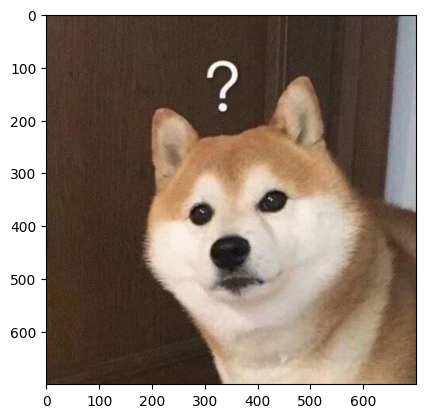

In [3]:
image = cv2.imread("../../_static/images/chai.jpg")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.Normalize(mean=[103.530, 116.280, 123.675], std=[57.375, 57.120, 58.395]),  # BGR
    T.ToMode("CHW"),
])
processed_img = transform.apply(image)[np.newaxis, :]  # CHW -> 1CHW
processed_img = megengine.tensor(processed_img)
print(processed_img.shape)

接下来我们直接测试这张图片经过预训练模型模型会得到什么样的预测结果：

In [4]:
model.eval()

logits = model(processed_img)
probs = F.softmax(logits) # 获取预测概率
result = F.argmax(probs)  # 得到最大概率的标签编号
print(result)

Tensor(250, dtype=int32, device=xpux:0)


查询 ImageNet 相关的标签信息后发现，250 代表该图片被预测为 “Siberian husky” 即哈士奇。

ImageNet 中并没有 “Shiba Inu” 这一分类，因此无法直接预测正确，当它确实被预测在狗的分类范围内，说明预训练模型是有效的。

### 模型微调

我们首先打印出该 ResNet 的结构：

In [5]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (downsample): Identity()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=T

In [6]:
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


可以发现，模型最后的输出 `out_features` 为 1000 类，想要在 CIFAR10 图片分类任务上使用该模型，需要进行一定的微调（Finetune）。

- 我们需要将最后的线性层输出由 1000 类修改为 10 类，这样在预测时标签才能对上；
- 在最后一层的线性层替换后，我们需要进行一定的再训练，达到模型微调的目的。

我们先完成第一步，即修改模型的部分结构。实现起来十分简单：

In [7]:
model.fc = M.Linear(512, 10)
print(model.fc)

Linear(in_features=512, out_features=10, bias=True)


接下来要考虑微调的具体方式：

- 最后的 `fc` 层是一定需要进行参数训练的，因为我们刚对其完成了替换，里面的参数处于刚初始化的状态；
- 我们也可以选择微调部分已有结构的卷积、池化参数来节省计算量，调整后的 Module 同样需要被训练；
- 除此以外，我们也可以选择对整个模型进行几轮完整的训练，以达到更好的效果，这取决于希望投入多少训练用时。

### 参数再训练

为了节省时间，我们这里选择仅对最后一层 `fc` 层的参数进行训练，这样可以减少大量的梯度计算：

In [8]:
train_dataset = data.dataset.CIFAR10(root="/data/datasets/CIFAR10/", train=True, download=False)
train_sampler = data.SequentialSampler(dataset=train_dataset, batch_size=64)
train_dataloader = data.DataLoader(
    train_dataset,
    train_sampler,
    transform = T.Compose([
            T.Resize(224),
            T.Normalize(   # 查询到 CIFAR10 的 mean 和 std 值，也可以自己统计计算
                mean=[0.4913997551666284, 0.48215855929893703, 0.4465309133731618],
                std=[0.24703225141799082, 0.24348516474564, 0.26158783926049628]
            ),
            T.ToMode('CHW'),
    ])
)

In [9]:
import time

gm = autodiff.GradManager().attach(model.fc.parameters())  # 注意这里传入的是 fc 的参数
optimizer = optim.SGD(model.fc.parameters(), lr=0.025, momentum=0.1, weight_decay=1e-4)

model.train()
start_time = time.time()
for epoch in range(3):

    running_loss = 0
    nums_train = 0

    for batch_data, batch_label in train_dataloader:
        batch_data = megengine.tensor(batch_data).astype("float32")
        batch_label = megengine.tensor(batch_label)
        with gm:
            pred = model(batch_data)
            loss = F.loss.cross_entropy(pred, batch_label)
            gm.backward(loss)
            optimizer.step().clear_grad()
        running_loss +=  loss.item()
        nums_train += len(batch_data)

    print("epoch = {}, loss = {:.6f}, time elapsed: {:.2f} min".format(
        epoch+1, running_loss / nums_train, (time.time() - start_time)/60))

epoch = 1, loss = 0.013456, time elapsed: 1.82 min
epoch = 2, loss = 0.010246, time elapsed: 3.66 min
epoch = 3, loss = 0.009737, time elapsed: 5.49 min


In [10]:
test_dataset = data.dataset.CIFAR10(root="/data/datasets/CIFAR10/", train=False, download=False)
test_sampler = data.RandomSampler(dataset=test_dataset, batch_size=64)
test_dataloader = data.DataLoader(
    test_dataset,
    test_sampler,
    transform = T.Compose([
            T.Resize(224),
            T.Normalize(   # 预处理操作需要保持一致
                mean=[0.4913997551666284, 0.48215855929893703, 0.4465309133731618],
                std=[0.24703225141799082, 0.24348516474564, 0.26158783926049628]
            ),
            T.ToMode('CHW'),
    ])
)

In [11]:
model.eval()
nums_correct = 0
nums_test = 0

start_time = time.time()
for batch_data, batch_label in test_dataloader:
    batch_data = megengine.tensor(batch_data).astype("float32")
    batch_label = megengine.tensor(batch_label)
    logits = model(batch_data)
    pred = F.argmax(logits, axis=1)
    nums_correct += (pred == batch_label).sum().item()
    nums_test += len(batch_data)
print("Accuracy = {:.3f}, time elapsed: {:.2f} min".format(
    nums_correct / nums_test, (time.time() - start_time)/60))

Accuracy = 0.775, time elapsed: 0.36 min


我们这里仅训练了 3 个周期，就达到了接近 80% 的精度，如果你更加精细地微调 ResNet 模型，最终在 CIFAR10 分类任务上取得超过 90% 的预测准确性。
达到满意的效果后，你也可以借助 MegEngine Hub, 将你训练好的模型作为预训练模型，供其他人在将来进行使用。

不过此时你或许发现了，在使用大模型时，哪怕仅仅进行前向计算（推理），也会用掉非常多的时间。

## 模型部署应用

从整个机器学习流程来看，我们已经经过了数据采集和算法模型设计的步骤，能够产出所需要的算法模型了。

但我们的最终目的是用模型进行推理，即能够对新的数据进行预测，就好像我们上面使用柴犬图片对 ResNet 预训练模型进行验证时所做的操作一样。

- 这与评估测试集时的方式一致，将需要用于推理的数据经过模型的前向过程，得到预测的输出结果；
- 借助这种思路，我们可以写个验证脚本，或使用类似于 Flask 这样的 Python Web 服务来进行简单的部署应用。

但是在实际的生产环境中，我们除了考虑推理的效果，还需要考虑到不同的平台和设备之间的差异，以及推理的速度。

- 高性能：例如在一些对实时性有要求的场景中，比如人脸检测和识别，我们除了希望保证精度，也希望推理速度越快越好；
- 拓展性：我们还会希望模型能够在端侧进行推理（网页、手机等设备），而不是集中在一个设备上，因此要对各种平台设备都有兼容；
- 轻量级：在测试情景下一般无法提供高性能计算设备，在一些嵌入式设备中，尤其是需要考虑硬件性能和功耗的限制。

从学术界的 SOTA 模型到真正的部署应用落地，这中间其实还有很长的一段路要走。

### 训推一体

MegEngine 的特点是训练推理的一体化，这意味着框架本身提供了强大的推理需求支持，追求极致的性能：

- 通常使用其他框架训练得到的模型，需要经过转换为类似 ONNX 标准格式的步骤，才能够在其它的推理平台上进行使用；
- 如果训练侧、中间格式、推理侧的一些算子没有完整支持，就意味着很难走通从训练到推理的流程；
- 而使用 MegEngine 训练得到的模型，可以直接利用 MegEngine 提供的推理接口，在不同的平台和设备上部署。

不过为了实现这一目标，我们需要导出一个经过优化的模型文件，描述了我们的计算图结构和参数信息。

而此前我们一致没有提到的是，在 MegEngine 中，计算图存在着动态和静态两种模式：

- 默认使用动态图模式进行训练，动态即计算图的构建和计算同时发生，这种模式有利于在开发模型时进行调试；
- 我们也可以切换到静态图模式获取更多的全局信息，这给各种优化都提供了可能性。

### 动静结合

在 MegEngine 中提供了 `jit` 子包，通过及时编译，利用 `jit.trace` 装饰器将计算图由 [动态转换成静态模式](https://megengine-docs.iap.hh-b.brainpp.cn/user-guide/model-development/jit/trace.html) ：

- 将循环内的网络计算函数，如下面例子中的 `inference_func()` ；
- 将网络所需输入作为训练函数的参数，并返回任意你需要的结果（如计算图的结果和损失函数值）；
- 用 `jit` 模块中的 `trace` 装饰器来装饰这个函数，将其中的代码变为静态图代码。

在将模型导出之前，我们需要至少调用一次被 `trace` 的函数，可以生成随机数据（符合输入形状要求）来完成：

In [12]:
from megengine.jit import trace

model.eval()
@trace(symbolic=True, capture_as_const=True)
def inference_func(data, model):
    logits = model(data)
    pred = F.softmax(logits, axis=1)
    return pred

np.random.seed(20200325)
data = megengine.tensor(np.random.random([1, 3, 224, 224]).astype(np.float32))
inference_func(data, model=model)

Tensor([[0.0191 0.0027 0.609  0.0661 0.2427 0.0158 0.0272 0.007  0.0105 0.    ]], device=xpux:0)

接着我们可以通过 `dump` 接口将模型导出，满足我们进行推理部署的需求：

- 这个过程中会出现一些 Warning 信息，目前我们不需要了解背后的细节；
- 取消掉下面的注释后运行，我们的模型文件将会导出到当前目录所在路径；

In [13]:
# inference_func.dump("resnet.mge")

### MegEngine Lite

想要使用该模型文件，我们可以使用由 MegEngine Lite 封装好的接口，但这不是我们现在关注的重点。

- 我们需要明白的是，MegEngine 底层为不同平台不同设备的推理情景做了许多的优化，实现了训推一体；
- 在训练模型时，我们通常会使用动态图模式，因为其方便调试；
- 而当存在推理部署的需求时，我们会使用静态图模式，追求极致的优化；

我们会在后续系列的教程中进一步地探索这些功能，它们已经超出了当前零基础教程的范围。

时刻回顾很重要，接下来我们需要花一些时间消化在整个系列教程中接触到的东西。

## 零基础教程系列回顾

在整个 MegEngine 零基础教程中，我们循序渐进地讲述了如何从零到一地去开发一个神经网络模型：

- 首先我们接触了 Tensor 和 Functional 两个子包，前者定义数据结构，后者实现基本计算；
- 在处理输入数据时，我们会用到 Data 子包，尤其是会用到里面的 Dataloader;
- 借助于 Autodiff 和 Optimizer 子包，我们能很方便地做到自动微分和梯度更新；
- 为了灵活设计更加复杂的网络结构，我们用到了 Module 子包，里面有各种经典层的实现；
- 我们可以使用 Hub 子包来获取预训练模型文件，也可以发布自己的预训练模型；
- 想要将模型部署到实际的生产环境中，我们还需要利用 Jit 子包将计算图转化为静态模式。

通过计算机视觉中最基本的分类任务，我们实现了完整的 AlexNet 模型，也了解了一些经典的模型结构。

## 问题思考：接下来做什么

本系列 MegEngine 零基础教程的目的在于提供一个稳定可复现的简单情景，以帮助读者了解最简单的概念。

经过最基本的练习后，接下来我们将进入日常使用阶段，逐渐地会碰到许多不同的情况，大致分为两类：

- 你需要更加了解一些已经学习过的子包的使用细节，来解决那些没有在教程中提到的问题；
- 你需要学习 MegEngine 中的一些新功能，通常这需要你接触之前从未接触过的新功能或概念。

对于第一种情况，我们可以选择阅读 MegEngine 文档的用户指南板块，里面对各个子包的使用都有具体的讲解。
比如我们可以更加深入地了解 Tensor 这一数据结构，也可以学习 Optimizer 在参数优化时的一些进阶用法。
相较于教程，用户指南更倾向于帮助你理解如何解决特定的问题。
第二种情况也十分常见，比如当你存在分布式训练的需求时，你将会需要学习 Distributed 子包和对应接口的使用，
从最简单的单机单卡训练，到单机多卡、甚至是多机多卡的训练情景，也有可能要从最基本的概念开始学起；
MegEngine 中还实现类似了 DTR/Sublinear 等显存优化，开启后通常能使用更大的 bathch size 进行训练；
为了追求极致的速度，你还可以尝试使用量化和混合精度训练等功能... 这都需要一定的时间去接触和学习。

上面这些情景都属于模型开发阶段，当你想要进行模型的推理部署时，基本上也会碰到类似的情景。

总而言之，我们会不断地在学习者和使用者的模式之间不断切换。

在学习时尝试寻找更多类似教程这样的材料，他们不一定来自于 MegEngine 官方文档，可能是一篇博客、一个问答、或一堂讲座；
而在日常使用时，如果忘记了某些步骤和细节，通常可以借助查阅 MegEngine 官方的用户指南来解决。
如果遇到无法解决的问题，一种可行的途径是尝试在 [MegEngine 社区](https://megengine.org.cn/community/) 寻找帮助。
只有不断地使用 MegEngine, 遇到 Bug 时学会主动地向开发人员反馈，我们的能力才能得到提升，同时MegEngine 也能走得更远。